# NAMES: Timothy Barao, Marlan McInnes-Taylor
# FSUIDS: tjb13b, mm05f

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [2]:
class FSA:
    def __init__(self, xt, yt, xv, yv):
        self.load_data(xt, yt, xv, yv)
        
        self.s = 0.001
        self.u = 50 #100
        self.N_iter = 500
        self.lr = 20       #Try 20

        #self.B_0 = 0
 
        self.M = self.x_t.shape[1]
        self.N = self.x_t.shape[0]
        self.B = np.zeros(self.M)
        # self.k = [10, 30, 100, 300, 500]
        
        self.losses = []
    
    
    def load_data(self, x_train_file, y_train_file, x_valid_file, y_valid_file):
        with open(x_train_file) as file:
            
            if "dexter" in x_train_file:
                self.x_t = pd.read_csv(file, delim_whitespace=False, header=None)
            else:    
                self.x_t = pd.read_csv(file, delim_whitespace=True, header=None)
            self.x_t = self.x_t.to_numpy(dtype=np.float64)

        with open(y_train_file) as file:
            self.y_t = pd.read_csv(file, header=None)
            self.y_t = self.y_t.to_numpy(dtype=np.float64)

        with open(x_valid_file) as file:
            
            if "dexter" in x_valid_file:
                self.x_v = pd.read_csv(file, delim_whitespace=False, header=None)
            else:    
                self.x_v = pd.read_csv(file, delim_whitespace=True, header=None)
            self.x_v = self.x_v.to_numpy(dtype=np.float64)
            
        with open(y_valid_file) as file:
            self.y_v = pd.read_csv(file, header=None)
            self.y_v = self.y_v.to_numpy(dtype=np.float64)

        self.N = self.x_t.shape[0]   # Rows
        self.M = self.x_t.shape[1]   # Columns 

        # Standardize data
        for i in range(0, self.M):
            if (not np.any(self.x_v[:, i])):
                self.x_v[:, i].fill(0)
            else:  
                self.x_v[:, i] = (self.x_v[:, i] - np.mean(self.x_v[:, i]))/(np.std(self.x_v[:, i]))

            if(not np.any(self.x_t[:, i])):
                self.x_t[:, i].fill(0)
            else:
                self.x_t[:, i] = (self.x_t[:, i] - np.mean(self.x_t[:, i]))/(np.std(self.x_t[:, i]))  
        
        self.x_v = np.insert(self.x_v, 0, 1, axis=1)
        self.x_t = np.insert(self.x_t, 0, 1, axis=1)

                
    def gradient_update(self):
        loss = self.loss()
        # self.B = self.B - self.lr * self.loss()
        self.B = self.B - self.lr * loss
        return self.B, loss
    
    def loss(self):
        #temp = np.sum(self.x_t*self.B, axis=1)
        temp = np.dot(self.x_t, self.B)
        temp = np.dot(temp, self.y_t.flatten())
        if temp > 1:
            temp = 0
        else:
            var = (temp - 1)**2
            temp = np.log(1 + var)
        '''
        for index in range(0, len(temp)):
            if temp[index] > 1:
                temp[index] = 0
            else:
                var = (temp[index] - 1)**2
                temp[index] = np.log(1 + var)
        '''            
        temp += self.s * LA.norm(self.B, 2)        
        temp /= self.N 
        return temp
        # 0            if x > 1
        # ln(1+(x-1)^2) else
    
    def predict(self):
        '''
        xB = np.matmul(self.x_t, self.B)
        yPred = np.sign(xB)
        print("Pred: ", yPred)
        print("y_t: ", self.y_t)
        print("xB: ", xB)'''
        
        
        xB = np.matmul(self.x_t, self.B)
        yPred = np.sign(xB)
        trainAcc = 1- np.mean(yPred == self.y_t.flatten().T)
        
        xB = np.matmul(self.x_v, self.B)
        yPred = np.sign(xB)
        testAcc = 1 - np.mean(yPred == self.y_v.flatten().T)
        return trainAcc, testAcc
    
    def train(self, k):
        mPrev = self.M
        for i in range(0, self.N_iter):
            if k == 30:
                B, loss = self.gradient_update()
                self.losses.append(loss)
            else:
                self.gradient_update()
            
            temp = (self.N_iter - 2 * i)/(2 * i * self.u + self.N_iter)
            temp = max(0., temp)
            mi = k + (self.M - k) * temp
            mi = int(mi)
            
            if mi < mPrev:
                indc = np.absolute(self.B)
                sort = np.argsort(indc)
                sort = sort[-mi:]
                self.B=self.B[sort]
                self.x_t=(self.x_t.T[sort]).T
                self.x_v=(self.x_v.T[sort]).T
                mPrev = mi
                
            #print("Iteration: ", i, "M_i: ", int(mi))
            #print('Non-zero count: ', np.count_nonzero(self.B))
            
        return 0
    
    
    def print_features(self):
        print("X_train Objs: ", self.x_t.shape[0], "X_train Feats: ", self.x_t.shape[1])
        print("Y_train Objs: ", self.y_t.shape[0])

        print("\nX_valid Objs: ", self.x_v.shape[0], "X_valid Feats: ", self.x_v.shape[1])
        print("Y_valid Objs: ", self.y_v.shape[0])

                
        #self.x_t, self.y_t, self.x_v, self.y_v = x_train, y_train, x_valid, y_valid 


In [3]:
# Select k = [10, 30, 100, 300] features
# Plot the training loss vs iteration number k = 10
# Report in Table the misclassification errors on the training and testing set for models obtained for all k
# Plot the misclassification error on the training set and testing set vs k

In [4]:
K = [10, 30, 100, 300, 500]
trainErrors = []
testErrors = []

# Madelon

In [5]:
x_train_file = "../data/MADELON/madelon_train.data"
y_train_file = "../data/MADELON/madelon_train.labels"

x_valid_file = "../data/MADELON/madelon_valid.data"
y_valid_file = "../data/MADELON/madelon_valid.labels"

In [6]:
#model = FSA(x_train_file, y_train_file, x_valid_file, y_valid_file)
#iterations = np.arange(0, model.N_iter)
for k in K:
    #model.print_features()
    model = FSA(x_train_file, y_train_file, x_valid_file, y_valid_file)
    xVals = np.arange(0, model.N_iter)
    model.train(k)
    trainAccuracy, testAccuracy = model.predict()
    trainErrors.append(round((1-trainAccuracy) * 100, 2))
    testErrors.append(round((1-testAccuracy) * 100, 2))
print("Train Errors: ", trainErrors)
print("Test Errors: ", testErrors)

Train Errors:  [52.05, 50.45, 51.75, 48.7, 49.2]
Test Errors:  [51.5, 50.83, 50.17, 45.83, 48.5]


ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

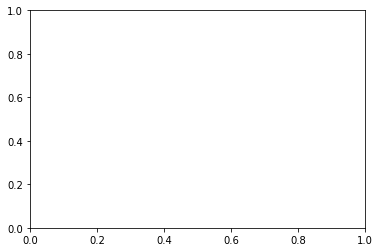

In [7]:
plt.plot(k, trainErrors, linestyle='-', marker='o', color='r', label='Train')
plt.plot(k, testErrors, linestyle='-', marker='o', color='b', label='Test')
plt.grid(True)
plt.xticks(k)
plt.title('Misclassification Error vs Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error (%)')
plt.legend()
plt.show()

plt.plot(xVals, model.losses, linestyle='-', marker='o', color='g')
plt.grid(True)
plt.xticks(xVals)
plt.title('Training Loss vs Iteration Number k=30')
plt.xlabel('Iteration Number (i)')
plt.ylabel('Training Loss (L_i)')
plt.show()

In [ ]:
plt.plot(k, trainErrors, linestyle='-', marker='o', color='r', label='Train')
plt.plot(k, testErrors, linestyle='-', marker='o', color='b', label='Test')
plt.grid(True)
plt.xticks(k)
plt.title('Misclassification Error vs Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error (%)')
plt.legend()
plt.show()

In [ ]:
errorTableMadelon = pd.DataFrame({"Training Error (%)":[0, 0, 0, 0, 0], "Test Error (%)":[0, 0, 0, 0, 0]}, index=K)
errorTableMadelon.index.name = "N Features"
for k, trainErr, testErr in zip(K, trainErrors, testErrors):
    errorTableMadelon.loc[k, 'Training Error (%)'] = trainErr
    errorTableMadelon.loc[k, 'Test Error (%)'] = testErr
    
errorTableMadelon

In [ ]:
trainErrors.clear()
testErrors.clear()

# Dexter

In [ ]:
x_train_file = "../data/dexter/dexter_train.csv"
y_train_file = "../data/dexter/dexter_train.labels"

x_valid_file = "../data/dexter/dexter_valid.csv"
y_valid_file = "../data/dexter/dexter_valid.labels"

In [ ]:
model = FSA(x_train_file, y_train_file, x_valid_file, y_valid_file)
model.print_features()

In [ ]:
plt.plot(xVals, model.losses, linestyle='-', marker='o', color='g')
plt.grid(True)
plt.xticks(xVals)
plt.title('Training Loss vs Iteration Number k=30')
plt.xlabel('Iteration Number (i)')
plt.ylabel('Training Loss (L_i)')
plt.show()

In [ ]:
plt.plot(k, trainErrors, linestyle='-', marker='o', color='r', label='Train')
plt.plot(k, testErrors, linestyle='-', marker='o', color='b', label='Test')
plt.grid(True)
plt.xticks(k)
plt.title('Misclassification Error vs Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error (%)')
plt.legend()
plt.show()

In [ ]:
errorTableDexter = pd.DataFrame({"Training Error (%)":[0, 0, 0, 0, 0], "Test Error (%)":[0, 0, 0, 0, 0]}, index=K)
errorTableDexter.index.name = "N Features"
for k, trainErr, testErr in zip(K, trainErrors, testErrors):
    errorTableDexter.loc[k, 'Training Error (%)'] = trainErr
    errorTableDexter.loc[k, 'Test Error (%)'] = testErr
    
errorTableMadelon

In [ ]:
trainErrors.clear()
testErrors.clear()

# Gisette 

In [ ]:
x_train_file = "../data/Gisette/gisette_train.data"
y_train_file = "../data/Gisette/gisette_train.labels"

x_valid_file = "../data/Gisette/gisette_valid.data"
y_valid_file = "../data/Gisette/gisette_valid.labels"

In [ ]:
model = FSA(x_train_file, y_train_file, x_valid_file, y_valid_file)
model.print_features()

In [ ]:
plt.plot(xVals, model.losses, linestyle='-', marker='o', color='g')
plt.grid(True)
plt.xticks(xVals)
plt.title('Training Loss vs Iteration Number k=30')
plt.xlabel('Iteration Number (i)')
plt.ylabel('Training Loss (L_i)')
plt.show()

In [ ]:
plt.plot(k, trainErrors, linestyle='-', marker='o', color='r', label='Train')
plt.plot(k, testErrors, linestyle='-', marker='o', color='b', label='Test')
plt.grid(True)
plt.xticks(k)
plt.title('Misclassification Error vs Number of Features')
plt.xlabel('Number of Features (k)')
plt.ylabel('Misclassification Error (%)')
plt.legend()
plt.show()

In [ ]:
errorTableGisette = pd.DataFrame({"Training Error (%)":[0, 0, 0, 0, 0], "Test Error (%)":[0, 0, 0, 0, 0]}, index=K)
errorTableGisette.index.name = "N Features"
for k, trainErr, testErr in zip(K, trainErrors, testErrors):
    errorTableGisette.loc[k, 'Training Error (%)'] = trainErr
    errorTableGisette.loc[k, 'Test Error (%)'] = testErr
    
errorTableMadelon

# Commented Code


In [ ]:
# In Load Data:    
    # x_valid = np.insert(x_valid, 0, 1, axis=1)
    # x_train = np.insert(x_train, 0, 1, axis=1)

    #y_valid = np.where(y_valid == -1, 0, y_valid)  
    #y_train = np.where(y_train == -1, 0, y_train)
    
                '''
                while np.count_nonzero(self.B) > mi:
                    minimum = np.amin(self.B, where=np.where(self.B != 0))
                    indices = np.where(self.B == minimum)
                    for index in indices:
                        self.B[index] = 0
                        if np.count_nonzero(self.B) == mi:
                            break    
                mPrev = mi
            '''